<a href="https://colab.research.google.com/github/mcnica89/DATA6100_F23/blob/main/Subset_Selection_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6.5.1 Best Subset Selection

In [ ]:
# imports and setup
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain, combinations
import statsmodels.api as sm

pd.set_option('precision', 2) # number precision for pandas
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', 12)
pd.set_option('display.float_format', '{:20,.2f}'.format) # get rid of scientific notation

plt.style.use('seaborn') # pretty matplotlib plots

In [ ]:
### Use these to download from file
#hitters = pd.read_csv('../datasets/Hitters.csv', index_col=0).dropna()

#Get this link from github by clicking "view raw"
url = 'https://raw.githubusercontent.com/mcnica89/ISL-python/master/datasets/Hitters.csv'
hitters = pd.read_csv(url,index_col=0).dropna()
hitters.index.name = 'Player'


hitters = hitters.iloc[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,18]] # push salary at the end
hitters['League'] = pd.get_dummies(hitters['League']).iloc[:, 0]
hitters['Division'] = pd.get_dummies(hitters['Division']).iloc[:, 0]
hitters['NewLeague'] = pd.get_dummies(hitters['NewLeague']).iloc[:, 0]


X = hitters.iloc[:, 0:19] #stats
y = hitters.iloc[:, 19] #salary info

# 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation

Heavily borrowed from:

https://nbviewer.jupyter.org/url/www.science.smith.edu/~jcrouser/SDS293/labs/lab9/Lab%209%20-%20Linear%20Model%20Selection%20in%20Python.ipynb

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)

In [ ]:
def processSubset(feature_set, X_train, y_train, X_test, y_test):
    # Fit model on feature_set and calculate RSS
    model = sm.OLS(y_train,X_train[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X_test[list(feature_set)]) - y_test) ** 2).sum()
    return {'features':feature_set, 'model':regr, 'RSS':RSS}

In [ ]:
def forward(predictors, X_train, y_train, X_test, y_test):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X_train.columns if p not in predictors]

    results = []

    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X_train, y_train, X_test, y_test))

    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    print("----Models:\n----", models['features'],models['RSS'])

    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]

    # Return the best model, along with some other useful information about the model
    return best_model

In [ ]:
models_train = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,len(X.columns)+1):
    models_train.loc[i] = forward(predictors, X_train, y_train, X_test, y_test)
    predictors = models_train.loc[i]['model'].model.exog_names

----Models:
---- 0         [AtBat]
1          [Hits]
2         [HmRun]
3          [Runs]
4           [RBI]
         ...     
14     [Division]
15      [PutOuts]
16      [Assists]
17       [Errors]
18    [NewLeague]
Name: features, Length: 19, dtype: object 0           22,259,489.25
1           20,399,756.10
2           29,198,924.52
3           21,198,084.07
4           20,610,028.67
             ...         
14          41,768,969.18
15          28,863,857.67
16          48,594,239.70
17          45,522,311.13
18          43,146,770.45
Name: RSS, Length: 19, dtype: float64
----Models:
---- 0         [CRuns, AtBat]
1          [CRuns, Hits]
2         [CRuns, HmRun]
3          [CRuns, Runs]
4           [CRuns, RBI]
             ...        
13     [CRuns, Division]
14      [CRuns, PutOuts]
15      [CRuns, Assists]
16       [CRuns, Errors]
17    [CRuns, NewLeague]
Name: features, Length: 18, dtype: object 0           14,713,247.28
1           13,583,448.02
2           15,904,285.61
3      

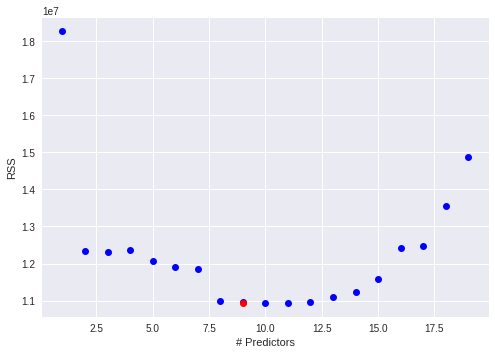

In [ ]:
plt.plot(models_train['RSS'],'ob')
plt.xlabel('# Predictors')
plt.ylabel('RSS')
plt.plot(models_train['RSS'].argmin(), models_train['RSS'].min(), 'or');

In [ ]:
models_full = pd.DataFrame(columns=['RSS', 'model'])

predictors = []

for i in range(1,20):
    models_full.loc[i] = forward(predictors, X, y, X, y)
    predictors = models_full.loc[i]['model'].model.exog_names

----Models:
---- 0         [AtBat]
1          [Hits]
2         [HmRun]
3          [Runs]
4           [RBI]
         ...     
14     [Division]
15      [PutOuts]
16      [Assists]
17       [Errors]
18    [NewLeague]
Name: features, Length: 19, dtype: object 0           45,080,439.91
1           43,213,925.91
2           57,431,824.21
3           44,711,058.25
4           43,477,958.63
             ...         
14          78,583,864.75
15          68,224,128.72
16          96,876,484.61
17          81,644,546.59
18          88,179,918.60
Name: RSS, Length: 19, dtype: float64
----Models:
---- 0         [Hits, AtBat]
1         [Hits, HmRun]
2          [Hits, Runs]
3           [Hits, RBI]
4         [Hits, Walks]
            ...        
13     [Hits, Division]
14      [Hits, PutOuts]
15      [Hits, Assists]
16       [Hits, Errors]
17    [Hits, NewLeague]
Name: features, Length: 18, dtype: object 0           43,019,957.50
1           42,292,193.93
2           43,092,710.79
3           41,644

In [ ]:
print(sorted(models_train.loc[10, 'model'].model.exog_names))

print(sorted(models_full.loc[10, 'model'].model.exog_names))

['Assists', 'AtBat', 'CRBI', 'CRuns', 'CWalks', 'Division', 'Hits', 'League', 'PutOuts', 'Runs']
['Assists', 'AtBat', 'CAtBat', 'CRBI', 'CRuns', 'CWalks', 'Division', 'Hits', 'PutOuts', 'Walks']
